# 05_Smart_Charging

timeThis notebook deals with task 5, smart charging. It defines an environment and a Markov decision process with states, actions, and rewards. The agent is initialized with a random battery capacity, has random energy demand, and finds an optimal policy to take the optimal action given the current time and charge. <br>

* Charging Environment
* SARSA
* Q-Learning
* Double Q-Learning

In [3]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import math
import gym
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

## Charging Environment

First, we need to define the environment for our charging agent. Here, we initialize and reset the environment and its properties. We also define the rewards for actions as well as the proceding state.

### Environment

In [2]:
# Define the ChargingEnvironment class
class ChargingEnvironment(gym.Env):
    def __init__(self, mu, sigma, battery_capacity, highest_rate):
        super(ChargingEnvironment, self).__init__()
        self.mu = mu
        self.sigma = sigma
        self.battery_capacity = battery_capacity
        self.highest_rate = highest_rate
        self.action_space = gym.spaces.Discrete(6)  # Updated action space
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([24, battery_capacity]))

    def reset(self):
        self.current_time = 2  # Starting time (2 p.m.)
#        self.current_charge = random.randint(15, 25)
        self.current_charge = random.randint(20, 25)
        #self.current_charge = 20
        self.energy_demand = np.random.normal(self.mu, self.sigma)
        #self.energy_demand = 30
        return np.array([self.current_time, self.current_charge])

    def step(self, action):
        done = False
        charging_power = np.clip(action * 4, 0, self.highest_rate)  # Limit charging_power to [0, 4, 8, 12, 16, 20]
        #print("Action: " + str(charging_power))
        energy_charging = charging_power / 4  # Energy charging in 15 minutes
        self.current_time += 0.25  # Increment time by 15 minutes
        self.current_charge += energy_charging
        if(self.current_charge > 50):
          self.current_charge = 50
        if(charging_power == 0):
          reward = 0
        else:
          reward = (0.25 * math.exp(charging_power)) * -1

        if self.current_time >= 4:
            if self.current_charge - self.energy_demand <= 0:
                reward -= 1000000000
                #reward -= 10000000
                #reward -= 100000000
            done = True
        next_state = np.array([self.current_time, self.current_charge])
        return next_state, reward, done, {}

### Distribution of Demand

Now, let us have a look at the distribution of energy demand. We can see that the probability of the demand exceeding 40 kWh is lower than 2.5 %, the probability for more than 45 kWh is lower than 0.15 %, and the probability for more than 50 kWh is 0.00 %. Thus, the maximum battery capacity of 50 kWh is not realistically exceeded by the demand. <br> <br>
Considering the probabilities for 45 to 50 kWh, we can assume that the agent(s) will probably aim at charging the battery up to that range to avoid the penalty for running out of charge.

Probability of value being higher than 40: 0.0228
Probability of value being higher than 41: 0.0139
Probability of value being higher than 42: 0.0082
Probability of value being higher than 43: 0.0047
Probability of value being higher than 44: 0.0026
Probability of value being higher than 45: 0.0013
Probability of value being higher than 46: 0.0007
Probability of value being higher than 47: 0.0003
Probability of value being higher than 48: 0.0002
Probability of value being higher than 49: 0.0001
Probability of value being higher than 50: 0.0000


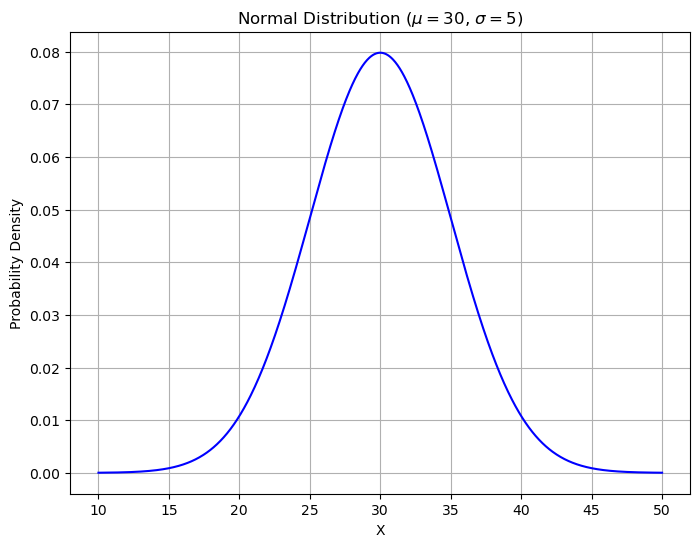

In [112]:
# Parameters for the normal distribution
mean = 30
sigma = 5

# Threshold values
thresholds = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

# Calculate the probabilities
probabilities = [1 - stats.norm.cdf(threshold, loc=mean, scale=sigma) for threshold in thresholds]

# Print the probabilities
for threshold, prob in zip(thresholds, probabilities):
    print(f"Probability of value being higher than {threshold}: {prob:.4f}")


# Generate data points for the x-axis
x = np.linspace(mean - 4*sigma, mean + 4*sigma, 1000)

# Calculate the corresponding probability density function (PDF) values
pdf = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * sigma**2))

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, pdf, color='blue')
plt.title('Normal Distribution ($\mu=30$, $\sigma=5$)')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


### Complementary Methods

Here, we want to check whether or not the learnt Q-tables induce a (near-)optimal policy.

In [7]:
def plotRunningAverage(totalrewards):
    """
    Plots the running average of rewards over time
    
    Args: 
        totalrewards: The total rewards of an episode
        
    """
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [138]:
def printOptimalActionsAndRewards(Q, env):
    """
    Prints a random episode using random initialization and action selection using the learnt Q-table

    Args:
        Q: The Q-table learnt by the algorithm
        env: The initialized ChargingEnvironment
    """
    done = False
    state = ChargingEnvironment.reset(env) 
    totalrewards_optimal = 0
    while not done:
        action = maxAction(Q, state)
        next_state, reward, done, info = ChargingEnvironment.step(env, action)
        
        print("Time =", state[0])
        print("Charge =", state[1])
        print("Optimal Action =", action)
        print("Reward =", reward)
        print()
        
        totalrewards_optimal += reward
        state = next_state
        
    print("Time =", state[0])
    print("Charge =", state[1])
    print("Total Reward =", totalrewards_optimal)

In [6]:
def getQTable(Q):
    """
    Creates a dataframe using the learnt Q-table 

    Args:
        Q: The Q-table learnt by the algorithm
        
    Returns:
        df: The dataframe containing the Q-table
    """
    
    # Extract keys and values from the dictionary
    keys = list(Q.keys())
    values = list(Q.values())

    # Separate the keys into time, charge, action, and index components
    time_list = [key[0][0] for key in keys]
    charge_list = [key[0][1] for key in keys]
    action_list = [key[1] for key in keys]
    value_list = values

    # Create a dictionary from the lists
    data = {
        'Time': time_list,
        'Charge': charge_list,
        'Action': action_list,
        'Value': value_list
    }

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(data)
    return(df)

## SARSA

Our first approach to finding an optimal policy is to use the SARSA algorithm.

In [154]:
def maxActionSARSA(Q, state):
    state_tuple = tuple(state)
    values = np.array([Q_SARSA[state_tuple, a] for a in range(6)])
    action = np.argmax(values)
    return action



#construct state space
states = []
# Time and charging rate
for i in range(9):
    t = 2 + i * 0.25
    for j in range(51):
          states.append((t,j))

Q_SARSA = {}
for s in states:
    for a in range(6):
        Q_SARSA[s, a] = 0



ALPHA = 0.01
GAMMA = 0.9
EPS = 1.0

env = ChargingEnvironment(mu=30, sigma=5, battery_capacity=50, highest_rate=22)

numGames = 100000
totalRewards = np.zeros(numGames)
for i in range(numGames):

      #print('starting game', i)
      s = ChargingEnvironment.reset(env)
#      s = getState(observation)
      rand = np.random.random()
      a = maxAction(Q_SARSA, s) if rand < (1-EPS) else env.action_space.sample()
      done = False
      epRewards = 0
      while not done:
          next_state, reward, done, info = ChargingEnvironment.step(env,a)
          s_ = next_state
          rand = np.random.random()
          a_ = maxAction(Q_SARSA, s_) if rand < (1-EPS) else env.action_space.sample()
          epRewards += reward
          Q_SARSA[tuple(s), a] = Q_SARSA[tuple(s), a] + ALPHA * (reward + GAMMA * Q_SARSA[tuple(s_), a_] - Q_SARSA[tuple(s), a])
          s, a = s_, a_
#      EPS -= 2/(numGames / 100) if EPS > 0 else 0
      EPS -= 2/(numGames / 1000) if EPS > 0 else 0
      totalRewards_SARSA[i] = epRewards
      if i % 1000 == 0:
            print(totalRewards_SARSA[i])

-123554260.41992605
-2263016.1656285124
-4484516.496680465
-2343593.723691221
-2305154.393864259
-1000041447.5868889
-2346574.6816782625
-125792.29104805509
-4565880.242852458
-4565866.5933149485
-2386518.1400362533
-2345111.501759758
-244891.07616277455
-4606555.2911697
-2221541.2796644764
-2424971.119400723
-121495501.2307556
-2424998.418475739
-6745973.935627914
-4565880.242852457
-4605823.7012104485
-244891.07616277455
-205679.20776403614
-245622.66612202668
-2506348.515110224
-2263.0175652978683
-244877.42662526626
-325509.5828380078
-2465673.466792982
-2466405.056752234
-1000040702.3473923
-2425730.008434992
-244877.42662526626
-4605823.701210448
-245622.66612202668
-2506348.515110225
-1000001504.128531
-4646498.749527691
-285566.1244800172
-325509.5828380078
-325509.5828380078
-4646512.399065199
-2426461.5983942435
-325509.5828380078
-285566.1244800172
-1004483798.5562587
-325509.5828380078
-8927571.7569344
-285566.1244800172
-325509.5828380078
-285566.1244800172
-285566.1244800

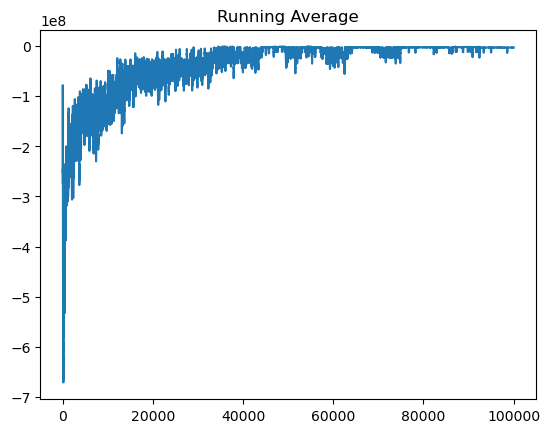

In [141]:
plotRunningAverage(totalRewards)

In [152]:
printOptimalActionsAndRewards(Q_SARSA, env)

Time = 2
Charge = 24
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.25
Charge = 27.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.5
Charge = 30.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.75
Charge = 33.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.0
Charge = 36.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.25
Charge = 39.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.5
Charge = 42.0
Optimal Action = 1
Reward = -13.649537508286059

Time = 3.75
Charge = 43.0
Optimal Action = 2
Reward = -745.2394967604321

Time = 4.0
Charge = 45.0
Total Reward = -244891.07616277455


## Q-Learning

Our next approach is the Q-Learning algorithm.

-121291298.85244757
-165004.1594467935
-1002344366.262263
-165735.74940604565
-123553542.4795043
-2346574.6816782625
-2466405.056752234
-2425716.3588974834
-4483757.607646195
-8968246.805251643
-2506348.515110225
-4687187.447382441
-4687187.447382442
-205679.2077640362
-2465673.466792982
-284834.5345207651
-2466405.056752234
-121536176.27907288
-4565880.242852457
-4646498.749527691
-2426461.598394243
-244891.07616277455
-4687187.447382442
-4687187.447382442
-9048865.311926875
-245622.66612202668
-121496232.82071489
-6786648.983945156
-2385786.550077001
-6868026.379654659
-4687187.447382442
-6868026.379654659
-2465659.8172554737
-6868026.379654659
-4687187.447382442
-6868026.379654658
-4687187.447382442
-2506348.515110225
-11229704.244199093
-2506348.515110225
-4687187.447382442
-9048865.311926875
-11229704.244199093
-6868026.379654659
-6868026.379654659
-4646512.399065199
-2465673.466792982
-11189029.19588185
-284834.53452076507
-9008190.263609633
-9008190.263609633
-9008190.263609633


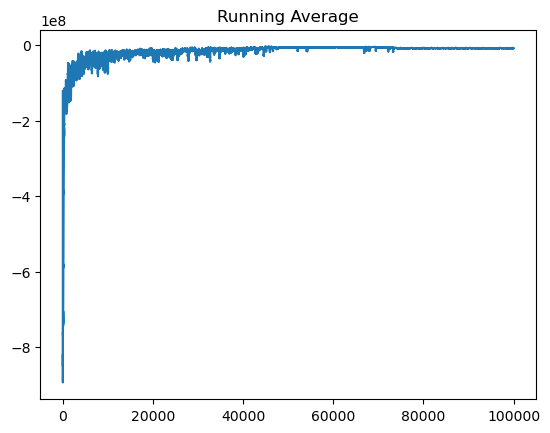

Time = 2
Charge = 21
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.25
Charge = 24.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.5
Charge = 27.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.75
Charge = 30.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.0
Charge = 34.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.25
Charge = 38.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.5
Charge = 42.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.75
Charge = 46.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 4.0
Charge = 50.0


In [21]:
def maxAction(Q, state):
    state_tuple = tuple(state)
    values = np.array([Q[state_tuple, a] for a in range(6)])
    action = np.argmax(values)
    return action





#construct state spaceb
states = []
# Time and charging rate
for i in range(9):
    t = 2 + i * 0.25
    for j in range(51):
          states.append((t,j))

Q = {}
for s in states:
    for a in range(6):
        Q[s, a] = 0



ALPHA = 0.1
GAMMA = 0.9
EPS = 1.0

env = ChargingEnvironment(mu=30, sigma=5, battery_capacity=50, highest_rate=22)

numGames = 100000
totalRewards = np.zeros(numGames)
for i in range(numGames):

      #print('starting game', i)
      s = ChargingEnvironment.reset(env)
#      s = getState(observation)
      rand = np.random.random()
      a = maxAction(Q, s) if rand < (1-EPS) else env.action_space.sample()
      done = False
      epRewards = 0
      while not done:
          next_state, reward, done, info = ChargingEnvironment.step(env,a)
          s_ = next_state
          rand = np.random.random()
          a_ = maxAction(Q, s_)
          epRewards += reward
          Q[tuple(s), a] = Q[tuple(s), a] + ALPHA * (reward + GAMMA * Q[tuple(s_), a_] - Q[tuple(s), a])
          s, a = s_, a_
#      EPS -= 2/(numGames / 100) if EPS > 0 else 0
      EPS -= 2/(numGames) if EPS > 0 else 0
      totalRewards[i] = epRewards
      if i % 1000 == 0:
            print(totalRewards[i])

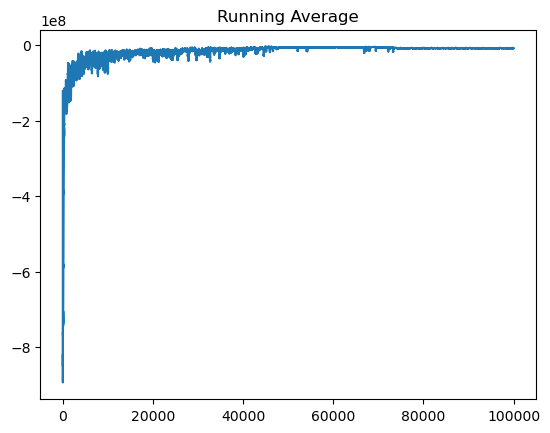

In [22]:
plotRunningAverage(totalRewards)

In [41]:
printOptimalActionsAndRewards(Q, env)

Time = 2
Charge = 21
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.25
Charge = 24.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.5
Charge = 27.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.75
Charge = 30.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.0
Charge = 34.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.25
Charge = 38.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.5
Charge = 42.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.75
Charge = 46.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 4.0
Charge = 50.0


## Double Q-Learning

Finally, we have a look at the performance of Double Q-Learning.

In [117]:
def maxAction(Q1,Q2,state):
    state_tuple = tuple(state)
    values = np.array([Q1[state_tuple, a] + Q2[state_tuple, a] for a in range(6)])
    action = np.argmax(values)
    return action




#construct state space
states = []
# Time and charging rate
for i in range(9):
    t = 2 + i * 0.25
    for j in range(51):
          states.append((t,j))

Q1, Q2 = {}, {}
for s in states:
    for a in range(6):
        Q1[s, a] = 0
        Q2[s, a] = 0



ALPHA = 0.1
GAMMA = 0.9
EPS = 1.0

env = ChargingEnvironment(mu=30, sigma=5, battery_capacity=50, highest_rate=22)

numGames = 150000
totalRewards = np.zeros(numGames)
for i in range(numGames):

      #print('starting game', i)
      s = ChargingEnvironment.reset(env)
      rand = np.random.random()
      done = False
      epRewards = 0
      while not done:
          rand = np.random.random()
          a = maxAction(Q1,Q2, s) if rand < (1-EPS) else env.action_space.sample()
          next_state, reward, done, info = ChargingEnvironment.step(env,a)
          s_ = next_state
          rand = np.random.random()
          epRewards += reward
          if rand <= 0.5:
              a_ = maxAction(Q1,Q1,s_)
              Q1[tuple(s),a] = Q1[tuple(s),a] + ALPHA*(reward + GAMMA*Q2[tuple(s_),a_] - Q1[tuple(s),a])
          elif rand > 0.5:
              a_ = maxAction(Q2,Q2,s_)
              Q2[tuple(s),a] = Q2[tuple(s),a] + ALPHA*(reward + GAMMA*Q1[tuple(s_),a_] - Q2[tuple(s),a])
          
          s = s_
      EPS -= 2/(numGames/ 1000) if EPS > 0 else 0
      totalRewards[i] = epRewards
      if i % 5000 == 0:
            print("Rewards of Game ", i, totalRewards[i])


Rewards of Game  0 -4606568.940707208
Rewards of Game  5000 -1000042192.8263857
Rewards of Game  10000 -125817221.98740456
Rewards of Game  15000 -6707520.956263444
Rewards of Game  20000 -125776560.5886248
Rewards of Game  25000 -9008176.614072125
Rewards of Game  30000 -8928303.346893651
Rewards of Game  35000 -15550693.410888776
Rewards of Game  40000 -13369854.478616558
Rewards of Game  45000 -9008176.614072125
Rewards of Game  50000 -11189015.546344342
Rewards of Game  55000 -6788139.4629386775
Rewards of Game  60000 -15550693.410888776
Rewards of Game  65000 -13369854.478616558
Rewards of Game  70000 -9008176.614072125
Rewards of Game  75000 -11189015.546344342
Rewards of Game  80000 -13369854.478616558
Rewards of Game  85000 -9008176.614072125
Rewards of Game  90000 -11189015.546344342
Rewards of Game  95000 -11189015.546344342
Rewards of Game  100000 -13369854.478616558
Rewards of Game  105000 -11189029.19588185
Rewards of Game  110000 -11149085.73752386
Rewards of Game  115000

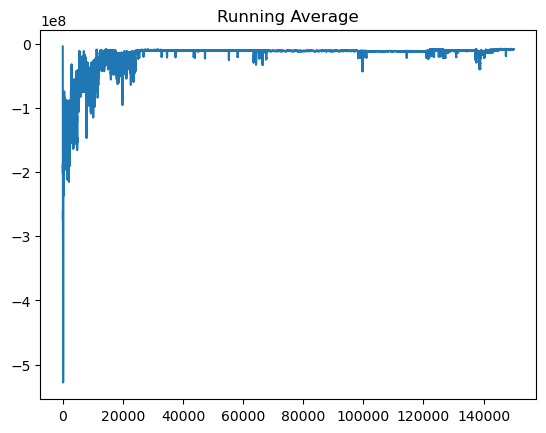

In [118]:
plotRunningAverage(totalRewards)

In [137]:
done = False    
state = ChargingEnvironment.reset(env) 
totalrewards_optimal = 0
while not done:
    action = maxAction(Q1, Q2, state)
    next_state, reward, done, info = ChargingEnvironment.step(env, action)
       
    print("Time =", state[0])
    print("Charge =", state[1])
    print("Optimal Action =", action)
    print("Reward =", reward)
    print()
     
    totalrewards_optimal += reward
    state = next_state
        
print("Time =", state[0])
print("Charge =", state[1])
print("Total Reward =", totalrewards_optimal)

Time = 2
Charge = 25
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.25
Charge = 28.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 2.5
Charge = 32.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 2.75
Charge = 36.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.0
Charge = 39.0
Optimal Action = 2
Reward = -745.2394967604321

Time = 3.25
Charge = 41.0
Optimal Action = 2
Reward = -745.2394967604321

Time = 3.5
Charge = 43.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.75
Charge = 47.0
Optimal Action = 2
Reward = -745.2394967604321

Time = 4.0
Charge = 49.0
Total Reward = -6748196.004580686
